In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob

from datetime import datetime, timedelta

from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb
from sklearn.metrics import roc_curve, auc

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import BatchNormalization
from sklearn.neural_network import MLPClassifier
from keras.layers import Dropout

%matplotlib inline

In [4]:
fraud_y1 =  pd.read_csv(r'/content/drive/MyDrive/DataFest Datathon/Copy of FraudDetectionDataset.csv')

In [ ]:
categorical_features = fraud_y1.select_dtypes(exclude=['number'])
numerical_features = fraud_y1.select_dtypes(include=['number'])

categorical_features = categorical_features.columns
numerical_features = numerical_features.columns

In [ ]:
features= fraud_y1.loc[:,numerical_features]
target = fraud_y1["Fraudulent Flag"]
best_features = SelectKBest(score_func=f_classif, k="all")
fit = best_features.fit(features,target)
# Create a DataFrame to store the ANOVA scores along with feature names
feature_scores = pd.DataFrame(data={'Feature': features.columns, 'ANOVA Score': fit.scores_})

feature_scores

/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: divide by zero encountered in divide
  f = msb / msw


,Feature,ANOVA Score
0,Transaction ID,2.901972
1,User ID,1.442068
2,Transaction Amount,0.024341
3,Merchant ID,0.218216
4,User Age,0.763290
5,User Income,1.767874
6,Location Distance,0.459064
7,Time Taken for Transaction,0.410656
8,User's Transaction History,3.419326
9,Merchant's Reputation Score,0.621496


In [ ]:
fraud_y1.nunique()

Transaction ID                       5805013
User ID                                 9000
Transaction Amount                     99901
Transaction Date and Time            5783314
Merchant ID                             9000
Payment Method                            40
Country Code                              40
Transaction Type                          38
Device Type                               38
IP Address                           5995699
Browser Type                              39
Operating System                          40
Merchant Category                         40
User Age                                  63
User Occupation                           26
User Income                          4498549
User Gender                                7
User Account Status                       18
Transaction Status                        40
Location Distance                       9901
Time Taken for Transaction              5901
Transaction Time of Day                    3
User's Tra

In [ ]:
fraud_y1.shape

(2321939, 33)

In [5]:
def process_dataset(df):
    # Convert 'Transaction Date' to datetime format
    df['Transaction Date and Time'] = pd.to_datetime(df['Transaction Date and Time'])

    # Group by 'User ID' and the chosen time frame
    grouped = df.groupby(['User ID', pd.Grouper(key='Transaction Date and Time')])

    # Calculate transaction frequency (count of transactions within the time frame)
    transaction_frequency = grouped.size().reset_index(name='Transaction Frequency')

    # Merge the calculated feature back into the original DataFrame
    df = pd.merge(df, transaction_frequency, on=['User ID', 'Transaction Date and Time'], how='left')

    df["Transaction Frequency"].fillna(0, inplace=True)

    # Extract day of the week (0 = Monday, 6 = Sunday)
    df['Day of the Week'] = df['Transaction Date and Time'].dt.dayofweek

    # Extract hour of the day (0-23)
    df['Hour of the Day'] = df['Transaction Date and Time'].dt.hour


    # Calculate the user's typical transaction amount (e.g., mean or median)
    user_typical_amount = df.groupby('User ID')['Transaction Amount'].mean()

    # Merge the user's typical transaction amount back into the original DataFrame
    df = df.merge(user_typical_amount, left_on='User ID', right_index=True, suffixes=('', '_UserAvg'))

    # Calculate the Transaction Amount Deviation
    df['Transaction Amount Deviation'] = df['Transaction Amount'] - df['Transaction Amount_UserAvg']

    # Calculate the Transaction Time Deviation
    user_typical_time = df.groupby('User ID')['Time Taken for Transaction'].mean()

    df = df.merge(user_typical_time, left_on='User ID', right_index=True, suffixes=('', '_UserAvg'))

    df['Transaction Time Deviation'] = df['Time Taken for Transaction'] - df['Time Taken for Transaction_UserAvg']


    # Calculate the Transaction Amount to Income Ratio
    df['Transaction Amount to Income Ratio'] = df['Transaction Amount'] / df['User Income']


    return df

fraud_y1 = process_dataset(fraud_y1)

In [6]:

# Define a function to classify values into 'Low', 'Mid', and 'High'
def classify_value(value, low_threshold, high_threshold):
    if value < low_threshold:
        return 1
    elif value < high_threshold:
        return 2
    else:
        return 3

col = ["Merchant's Reputation Score","User Age","Merchant's Business Age"]


# Automatically calculate low and high thresholds for each column using NumPy
for column in col:
    low_threshold = np.percentile(fraud_y1[column], 25)  # 25th percentile
    high_threshold = np.percentile(fraud_y1[column], 75)  # 75th percentile
    fraud_y1[column] = fraud_y1[column].apply(classify_value, args=(low_threshold, high_threshold))





In [7]:
def categorize_data(df):
    # Define the payment method categories using a dictionary
    payment_categories = {
        "Ethereum": "Mobile Payments","Cryptocurrency Wallet": "Mobile Payments","Klarna": "Online Payments","Debit Card": "Card Payments",
        "Contactless Payment": "Other Payment Methods","Amazon Pay": "Online Payments","Mobile Wallet": "Mobile Payments","Square Cash": "Mobile Payments",
        "Alipay": "Mobile Payments","Wire Transfer": "Transfers","2Checkout": "Online Payments","Visa Checkout": "Card Payments","ACH Transfer": "Online Payments",
        "Masterpass": "Card Payments","Diners Club": "Card Payments","Afterpay": "Other Payment Methods","Apple Pay": "Card Payments",
        "American Express": "Card Payments","Check": "Other Payment Methods","Stripe": "Online Payments","Bank Transfer": "Transfers","Money Order": "Other Payment Methods",
        "E-check": "Other Payment Methods","Western Union": "Online Payments","PayPal": "Online Payments","Skrill": "Online Payments","WeChat Pay": "Mobile Payments",
        "Credit Card": "Card Payments","NFC Payment": "Other Payment Methods","Neteller": "Online Payments","Direct Debit": "Online Payments","Payoneer": "Online Payments",
        "Cash": "Other Payment Methods","Discover": "Card Payments","Google Wallet": "Card Payments","Bitcoin": "Mobile Payments","Worldpay": "Online Payments",
        "Venmo": "Mobile Payments","JCB": "Card Payments","Prepaid Card": "Card Payments"
    }

    # Apply the categorization function to create a new column "Payment Category"
    df["Payment Category"] = df["Payment Method"].map(payment_categories)


    # Define the transaction categories using a dictionary
    transaction_categories = {
        "Cashback": "Other Transactions","Purchase": "Normal Financial Transactions","Recharge": "Normal Financial Transactions",
        "Reward": "Other Transactions","Registration Fee": "Government and Regulatory Transactions","Buyback": "Other Transactions",
        "Rental": "Other","Dividend": "Normal Financial Transactions","Auction": "Business and Trade Transactions","Admission": "Educational and Scholarly Transactions",
        "Interest": "Normal Financial Transactions","Bonus": "Normal Financial Transactions","Transfer": "Normal Financial Transactions",
        "Fine": "Government and Regulatory Transactions","Donation": "Charitable and Philanthropic Transactions","Gift": "Other","Tax": "Other Transactions",
        "Royalty": "Other Transactions","Contribution": "Other Transactions","Refund": "Other Transactions","Reimbursement": "Other Transactions",
        "Investment": "Normal Financial Transactions","Settlement": "Normal Financial Transactions","Service Charge": "Normal Financial Transactions",
        "Subscription": "Normal Financial Transactions","Expense": "Business and Trade Transactions","Membership": "Normal Financial Transactions",
        "Withdrawal": "Normal Financial Transactions","Deposit": "Normal Financial Transactions","Loan": "Normal Financial Transactions",
        "Rent": "Normal Financial Transactions","Invoice": "Normal Financial Transactions","Acquisition": "Other Transactions",
        "Compensation": "Normal Financial Transactions","Payment": "Normal Financial Transactions","Payout": "Normal Financial Transactions",
        "Scholarship": "Educational and Scholarly Transactions","Charity": "Charitable and Philanthropic Transactions"
    }

    # Apply the categorization function to create a new "Transaction Category" column
    df["Transaction Type_cat"] = df["Transaction Type"].map(transaction_categories)


    # Define the device categories using a dictionary
    device_categories = {
        "E-Reader": "Mobile and Portable Devices","Mobile":"Mobile and Portable Devices",
        "Smartphone": "Mobile and Portable Devices","Tablet": "Mobile and Portable Devices","Laptop": "Mobile and Portable Devices",
        "Wearable Device": "Mobile and Portable Devices","Smartwatch": "Mobile and Portable Devices",
        "Home Security System":"Other Devices","Smart Speaker": "Other Devices",
        "Smart Thermostat": "Other Devices","Smart Mirror": "Other Devices","Smart Doorbell": "Other Devices","Digital Camera": "Other Devices",
        "Fitness Tracker": "Other Devices","Smart TV": "Other Devices","Smart Lock": "Other Devices","IoT Device": "Other Devices",
        "Augmented Reality Glasses": "Other Devices","Home Automation Hub": "Other Devices",
        "Smart Appliance": "Other Devices","Virtual Reality Headset": "Other Devices","Robot": "Other Devices","Gaming Console": "Other Devices",
        "Medical Device": "Other Devices","Kiosk": "Retail and Commercial Devices","ATM": "Retail and Commercial Devices",
        "Barcode Scanner": "Retail and Commercial Devices","POS Terminal": "Retail and Commercial Devices","Self-Checkout Kiosk": "Retail and Commercial Devices",
        "Cash Register": "Retail and Commercial Devices","Vending Machine": "Retail and Commercial Devices","Industrial Controller": "Industrial and Automation Devices",
        "Server": "Industrial and Automation Devices","Desktop": "Industrial and Automation Devices","Embedded System": "Industrial and Automation Devices",
        "GPS Device": "Transportation and Navigation Devices","Vehicle Infotainment System": "Transportation and Navigation Devices","Drone": "Transportation and Navigation Devices"
        }

    # Create a new column "Device Category" using mapping
    df["Device Type Category"] = df["Device Type"].map(device_categories)

    # Define the browser security categories using a dictionary
    browser_security_categories = {
        "Firefox": "Generally High Security","Brave": "Generally High Security","Tor Browser": "Generally High Security","Avant Browser":"Generally High Security",
        "Chrome":"Moderate Security", "Chromium":"Moderate Security","Samsung Internet":"Moderate Security",
        "Opera":"Moderate Security","Safari": "Moderate Security","Edge": "Moderate Security","Vivaldi": "Moderate Security",
        "Internet Explorer": "Potentially Vulnerable","Maxthon": "Potentially Vulnerable","UC Browser": "Potentially Vulnerable",
        "Otter Browser": "Less Common Browsers","NetSurf": "Less Common Browsers",
        "Qutebrowser": "Less Common Browsers","Surfraw": "Less Common Browsers","Basilisk": "Less Common Browsers",
        "Beaker": "Less Common Browsers","Konqueror": "Less Common Browsers",
        "ELinks": "Less Common Browsers","Midori": "Less Common Browsers","Lynx": "Less Common Browsers","W3M": "Less Common Browsers",
        "Min": "Less Common Browsers","Surf": "Less Common Browsers","Vimb": "Less Common Browsers","Dooble": "Less Common Browsers",
        "Links": "Less Common Browsers","Browsh": "Less Common Browsers","Pale Moon": "Less Common Browsers","Falkon": "Less Common Browsers",
        "Slimjet":"Less Common Browsers","SRWare Iron": "Less Common Browsers","Silk":"Less Common Browsers" , "Waterfox":"Less Common Browsers",
        "SeaMonkey":"Less Common Browsers" ,"Epiphany":"Less Common Browsers"
    }

    # Create a new column "Browser Security Category" using mapping
    df["Browser Security Category"] = df["Browser Type"].map(browser_security_categories)

    # Define the operating system categories using a dictionary
    os_categories = {
        "Windows Server": "Microsoft Operating Systems","Windows Mobile": "Microsoft Operating Systems","Windows": "Microsoft Operating Systems",
        "Windows CE": "Microsoft Operating Systems","Windows 10": "Microsoft Operating Systems",
        "Red Hat Enterprise Linux": "Linux Distributions","CentOS": "Linux Distributions","Fedora": "Linux Distributions",
        "Linux": "Linux Distributions","openSUSE": "Linux Distributions","Debian": "Linux Distributions",
        "Gentoo": "Linux Distributions","Arch Linux": "Linux Distributions","Ubuntu": "Linux Distributions",
        "Solaris": "Unix-Based Operating Systems","HP-UX": "Unix-Based Operating Systems","AIX": "Unix-Based Operating Systems",
        "FreeBSD": "Unix-Based Operating Systems","Unix": "Unix-Based Operating Systems",
        "macOS": "macOS and iOS","macOS Server": "macOS and iOS","iOS": "macOS and iOS",
        "watchOS": "macOS and iOS","Mac OS X": "macOS and iOS",
        "Android Wear": "Android-Based Operating Systems","Android": "Android-Based Operating Systems","Android TV": "Android-Based Operating Systems",
        "tvOS": "Other Mobile and Embedded OS","Sailfish OS": "Other Mobile and Embedded OS","KaiOS": "Other Mobile and Embedded OS",
        "BlackBerry": "Other Mobile and Embedded OS","Palm OS": "Other Mobile and Embedded OS","Firefox OS": "Other Mobile and Embedded OS",
        "Tizen": "Other Mobile and Embedded OS","MeeGo": "Other Mobile and Embedded OS","HarmonyOS": "Other Mobile and Embedded OS",
        "Raspbian": "Other Mobile and Embedded OS","Chrome OS": "Other Mobile and Embedded OS","Chromebook": "Other Mobile and Embedded OS",
        "QNX": "Other Mobile and Embedded OS","Symbian": "Other Mobile and Embedded OS",
    }

    # Create a new column "Operating System Category" using mapping
    df["Operating System Category"] = df["Operating System"].map(os_categories)

    # Define the currency regions using a dictionary
    currency_regions = {
        "EGP": "Africa","ZAR": "Africa","KES": "Africa",
        "HKD": "Asia","THB": "Asia","SAR": "Asia","QAR": "Asia","MYR": "Asia","INR": "Asia","JPY": "Asia",
        "TRY": "Asia","CNY": "Asia","PHP": "Asia","VND": "Asia","ILS": "Asia","SGD": "Asia","IDN": "Asia","KRW": "Asia",
        "GBP": "Europe","NOK": "Europe","SEK": "Europe","EUR": "Europe","DKK": "Europe","PLN": "Europe","CZK": "Europe",
        "RON": "Europe","CHF": "Europe","HUF": "Europe","RUB": "Europe",
        "CAD": "America","USD": "America","MXN": "America","CLP": "America","COP": "America",
        "ARS": "America","PEN": "America","BRL": "America",
        "AUD": "Oceania","NZD": "Oceania",
        "AED": "Middle East",
    }

    # Create a new column "Currency Region" using mapping
    df["Transaction Currency Category"] = df["Transaction Currency"].map(currency_regions)

    # Define the country regions using a dictionary
    country_regions = {
        "VNM": "Asia","TAI": "Asia","QAT": "Asia","IDN": "Asia","ISR": "Asia","RUS": "Asia",
        "KOR": "Asia","MAL": "Asia","UAE": "Asia","SAU": "Asia","THA": "Asia","JPN":"Asia",
        "IND": "Asia","HKG": "Asia","CHN": "Asia","SGP": "Asia",
        "BEL": "Europe","AUT": "Europe","UK": "Europe","FRA": "Europe","SWE": "Europe",
        "NOR": "Europe","GRE": "Europe","GER": "Europe","TUR": "Europe","POL": "Europe","NLD": "Europe",
        "CHE": "Europe","ITA": "Europe","ESP": "Europe",
        "CAN": "America","USA": "America","MEX": "America","BRA": "America","ARG": "America",
        "ZAF": "Africa","EGY": "Africa","NGA": "Africa",
        "NZL": "Oceania",
        "AUS": "Oceania",
        "GRC": "Oceania",
    }

    # Create a new column "Country Region" using mapping
    df["Country Code Category"] = df["Country Code"].map(country_regions)

    # Define the category mapping using a dictionary
    category_mapping = {
        "Clothing": "Retail & Fashion","Jewelry": "Retail & Fashion","Luxury Brands": "Retail & Fashion","Appliances": "Home & Lifestyle",
        "Home & Garden": "Home & Lifestyle","Home Improvement": "Home & Lifestyle","Furniture": "Home & Lifestyle",
        "Sports & Outdoors": "Sports & Outdoors","Sporting Goods": "Sports & Outdoors","Automotive": "Business & Services",
        "Electronics Repair": "Business & Services","Charity & Nonprofit": "Business & Services","Financial Services": "Business & Services",
        "Industrial & Scientific": "Business & Services","Specialty Services": "Business & Services","Online Marketplace": "Business & Services",
        "Wholesale": "Business & Services","Technology": "Business & Services","Electronics": "Business & Services",
        "Entertainment": "Entertainment & Hobbies","Music & Instruments": "Entertainment & Hobbies","Toys & Games": "Entertainment & Hobbies",
        "Hobby & Crafts": "Entertainment & Hobbies","Books & Literature": "Entertainment & Hobbies","Beauty & Cosmetics": "Health & Well-being",
        "Fitness & Nutrition": "Health & Well-being","Health & Wellness": "Health & Well-being","Food & Beverage": "Health & Well-being",
        "Education": "Health & Well-being","Real Estate": "Health & Well-being","Pets & Animals": "Health & Well-being",
        "Subscription Services": "Health & Well-being","Travel & Tourism": "Health & Well-being",
        "Farm & Agriculture": "Other Categories","Vintage & Antique": "Other Categories","Office Supplies": "Other Categories","Wedding & Bridal": "Other Categories",
        "Art & Collectibles": "Other Categories","Baby & Maternity": "Other Categories","Gifts & Souvenirs": "Other Categories",
    }

    # Create a new column "Category" using mapping
    df["Merchant Cat"] = df["Merchant Category"].map(category_mapping)

    # Define the status mapping using a dictionary
    status_mapping = {
        "Resolved": "Completed","Closed": "Completed","Executed": "Completed","Settled": "Completed","Approved": "Completed","Processed": "Completed",
        "Received": "Completed","Completed": "Completed","Cleared": "Completed","Delivered": "Completed","Posted": "Completed","Credited": "Completed","Debit": "Completed",
        "Sent": "Pending","In Progress": "Pending","Pending Review": "Pending","Pending Payment": "Pending","Pending Confirmation": "Pending","Pending": "Pending",
        "Processing": "Pending","Authorized": "Pending","Partially Approved": "Pending","In Transit": "Pending","Partially Declined": "Pending",
        "Hold": "Pending","Under Review": "Pending","Awaiting Verification": "Pending",
        "Rejected": "Rejected/Declined","Declined": "Rejected/Declined","Failed": "Rejected/Declined","Void": "Rejected/Declined",
        "Blocked": "Rejected/Declined","Cancelled": "Rejected/Declined",
        "Unverified": "Unverified/Verified","Verified": "Unverified/Verified",
        "Refunded": "Refunded","Error": "Refunded",
        "Held for Security": "Refunded","Disputed": "Refunded","Transferred": "Refunded",
    }

    # Create a new column "Status Category" using mapping
    df["Transaction Status Category"] = df["Transaction Status"].map(status_mapping)

    # Define the authentication and verification method categories using a dictionary
    auth_verification_categories = {
        "NFC Tag": "Biometrics",
        "Iris Scan": "Biometrics",
        "Voiceprint": "Biometrics",
        "Handwriting Recognition": "Biometrics",
        "Palm Vein Scan": "Biometrics",
        "Retina Scan": "Biometrics",
        "Fingerprint": "Biometrics",
        "Biometric Scan": "Biometrics",
        "Time-Based OTP": "Time-Based and Token-Based",
        "SMS Code": "Time-Based and Token-Based",
        "Hardware Token": "Time-Based and Token-Based",
        "Certificate-based Authentication": "Time-Based and Token-Based",
        "Transaction Confirmation Number": "Time-Based and Token-Based",
        "Two-Factor Authentication": "Time-Based and Token-Based",
        "Token": "Time-Based and Token-Based",
        "PIN": "Time-Based and Token-Based",
        "Password": "Time-Based and Token-Based",
        "Signature Verification": "Signature and Voice Verification",
        "Voice Recognition": "Signature and Voice Verification",
        "Behavioral Biometrics": "Behavioral and Knowledge-Based",
        "Knowledge-Based Authentication": "Behavioral and Knowledge-Based",
        "Behavioral Analytics": "Behavioral and Knowledge-Based",
        "QR Code": "QR Code and Geolocation",
        "Geolocation Verification": "QR Code and Geolocation",
        "Mobile Phone Verification": "Mobile and App-Based",
        "Mobile App Notification": "Mobile and App-Based",
        "Smart Card": "Card and Radio-Frequency Identification (RFID)",
        "Biometric Card": "Card and Radio-Frequency Identification (RFID)",
        "Radio-Frequency Identification (RFID)": "Card and Radio-Frequency Identification (RFID)",
        "Social Media Login": "Other Authentication Methods",
        "Security Question": "Other Authentication Methods",
        "Face ID": "Other Authentication Methods",
        "Authentication App": "Other Authentication Methods",
        "Pattern Lock": "Other Authentication Methods",
        "USB Security Key": "Other Authentication Methods",
        "CAPTCHA": "Other Authentication Methods",
        "Email Verification": "Other Authentication Methods",
        "Bluetooth Authentication": "Other Authentication Methods",
        "Push Notification Confirmation": "Other Authentication Methods",
    }

    # Create a new column "Auth/Verification Category" using mapping
    df["Transaction Authentication Category"] = df["Transaction Authentication Method"].map(auth_verification_categories)

    # Define the transaction type categories using a dictionary
    transaction_type_categories = {
        "Retail Purchase": "Purchases and Payments",
        "Ticket Purchase": "Purchases and Payments",
        "Utility Payment": "Purchases and Payments",
        "Admission": "Purchases and Payments",
        "Registration Fee": "Purchases and Payments",
        "Membership": "Purchases and Payments",
        "Gift Purchase": "Purchases and Payments",
        "Service Charge": "Purchases and Payments",
        "Insurance Premium": "Purchases and Payments",
        "Subscription Renewal": "Purchases and Payments",
        "Investment": "Purchases and Payments",
        "Consultation Fee": "Purchases and Payments",
        "Product Purchase": "Purchases and Payments",
        "Rent": "Purchases and Payments",
        "Expense Reimbursement": "Purchases and Payments",
        "Fine Settlement": "Purchases and Payments",
        "Rental Payment": "Purchases and Payments",
        "Bill Payment": "Purchases and Payments",
        "Invoice Payment": "Purchases and Payments",
        "Recharge": "Purchases and Payments",
        "Cashback Reward": "Rewards and Earnings",
        "Bonus": "Rewards and Earnings",
        "Royalty": "Rewards and Earnings",
        "Dividend Reinvestment": "Rewards and Earnings",
        "Payout": "Rewards and Earnings",
        "Compensation": "Rewards and Earnings",
        "Scholarship": "Rewards and Earnings",
        "Interest Payment": "Rewards and Earnings",
        "Donation to Nonprofit": "Donations and Charity",
        "Charity Donation": "Donations and Charity",
        "Loan Repayment": "Financial Transactions",
        "Buyback": "Financial Transactions",
        "Tax Payment": "Financial Transactions",
        "Auction Bid": "Financial Transactions",
        "Settlement": "Financial Transactions",
        "Acquisition": "Financial Transactions",
        "Deposit": "Financial Transactions",
        "Transfer to Family": "Financial Transactions",
    }

    # Create a new column "Transaction Type Category" using mapping
    df["Transaction Purpose Category"] = df["Transaction Purpose"].map(transaction_type_categories)


    # Define the user status categories using a dictionary
    user_status_categories = {
        "Trial": "Active",
        "Limited": "Active",
        "Verified": "Active",
        "Standard": "Active",
        "Active": "Active",
        "New": "Active",
        "Guest": "Active",
        "Existing": "Active",
        "VIP": "Active",
        "Premium": "Active",
        "Member": "Active",
        "Free": "Active",
        "Pro": "Active",
        "Inactive": "Inactive",
        "Closed": "Inactive",
        "Pending Approval": "Pending",
        "Suspended": "Suspended",
        "Unverified": "Unverified",
    }

    # Create a new column "User Status Category" using mapping
    df["User Account Status Category"] = df["User Account Status"].map(user_status_categories)


    # Define the user device location categories using a dictionary
    user_location_categories = {
        "Australia": "Oceania",
        "New Zealand": "Oceania",
        "United States": "America",
        "Canada": "America",
        "Brazil": "America",
        "Argentina": "America",
        "Mexico":"America",
        "Spain": "Europe",
        "Norway": "Europe",
        "Germany": "Europe",
        "Belgium": "Europe",
        "United Kingdom": "Europe",
        "Netherlands": "Europe",
        "Austria": "Europe",
        "Italy": "Europe",
        "France": "Europe",
        "Poland": "Europe",
        "Sweden": "Europe",
        "Greece": "Europe",
        "Turkey": "Europe",
        "Switzerland": "Europe",
        "Russia": "Europe",
        "Singapore": "Asia",
        "South Korea": "Asia",
        "Taiwan": "Asia",
        "China": "Asia",
        "Hong Kong": "Asia",
        "Vietnam": "Asia",
        "Indonesia": "Asia",
        "Japan": "Asia",
        "India": "Asia",
        "Malaysia": "Asia",
        "Thailand": "Asia",
        "Qatar": "Middle East",
        "United Arab Emirates": "Middle East",
        "Israel": "Middle East",
        "South Africa": "Africa",
        "Nigeria": "Africa",
        "Egypt": "Africa",
        "Saudi Arabia": "Africa",
    }

    # Create a new column "User Location Category" using mapping
    df["User's Device Location Category"] = df["User's Device Location"].map(user_location_categories)


    # Define the user email domain categories using a dictionary
    email_domain_categories = {
        "gmail.com": "Popular Email Services",
        "outlook.com": "Popular Email Services",
        "icloud.com": "Popular Email Services",
        "zoho.com": "Popular Email Services",
        "fastmail.com": "Popular Email Services",
        "aim.com": "Popular Email Services",
        "gmx.com": "Popular Email Services",
        "live.com": "Popular Email Services",
        "cox.net": "Popular Email Services",
        "verizon.net": "Popular Email Services",
        "yahoo.com": "Popular Email Services",
        "mail.com": "Popular Email Services",
        "roadrunner.com": "Popular Email Services",
        "hotmail.com": "Popular Email Services",
        "aol.com": "Popular Email Services",
        "rocketmail.com": "Popular Email Services",
        "rediffmail.com":"Popular Email Services",
        "roadrunner.co.uk": "UK Email Services",
        "yahoo.co.uk": "UK Email Services",
        "gmail.co.uk": "UK Email Services",
        "verizon.co.uk": "UK Email Services",
        "icloud.co.uk": "UK Email Services",
        "protonmail.co.uk": "UK Email Services",
        "outlook.co.uk": "UK Email Services",
        "rocketmail.co.uk": "UK Email Services",
        "aim.co.uk": "UK Email Services",
        "zoho.co.uk": "UK Email Services",
        "fastmail.co.uk": "UK Email Services",
        "cox.co.uk": "UK Email Services",
        "rediffmail.co.uk": "UK Email Services",
        "tutanota.co.uk": "UK Email Services",
        "live.co.uk": "UK Email Services",
        "yandex.co.uk": "UK Email Services",
        "tutanota.com": "Other International Email Services",
        "yandex.com": "Other International Email Services",
        "protonmail.com": "Other International Email Services",
        "gmail.co.in": "Country-Specific Email Services",
        "yahoo.co.in": "Country-Specific Email Services",
        "gmail.ca": "Country-Specific Email Services",
        "yahoo.ca": "Country-Specific Email Services",

    }

    # Create a new column "Email Domain Category" using mapping
    df["Email Domain Category"] = df["User's Email Domain"].map(email_domain_categories)

    df = df.drop(["Device Type","Browser Type","Operating System","Transaction Currency","User's Email Domain",
             "User's Device Location","Country Code","Merchant Category","Transaction Status","Transaction Authentication Method",
             "Transaction Purpose","User Account Status","Payment Method","Transaction Type"], axis=1)

    return df

In [8]:
fraud_y1 = categorize_data(fraud_y1)

In [9]:
fraud_y1.drop(["Transaction ID","IP Address","Transaction Date and Time",],axis=1,inplace=True)

In [ ]:
categorical_features = fraud_y1.select_dtypes(exclude=['number'])  # Select non-numerical columns

In [ ]:
categorical_features.columns

Index(['User Occupation', 'User Gender', 'Transaction Time of Day',
       'Payment Category', 'Transaction Type_cat', 'Device Type Category',
       'Browser Security Category', 'Operating System Category',
       'Transaction Currency Category', 'Country Code Category',
       'Merchant Cat', 'Transaction Status Category',
       'Transaction Authentication Category', 'Transaction Purpose Category',
       'User Account Status Category', 'User's Device Location Category',
       'Email Domain Category'],
      dtype='object')

In [ ]:
fraud_y1.describe()

,Transaction ID,User ID,Transaction Amount,Merchant ID,User Age,User Income,Location Distance,Time Taken for Transaction,User's Transaction History,Merchant's Reputation Score,User's Credit Score,Merchant's Business Age,Fraudulent Flag
count,6.000000e+06,6.000000e+06,6.000000e+06,6.000000e+06,6.000000e+06,6.000000e+06,6.000000e+06,6.000000e+06,6.000000e+06,6.000000e+06,6.000000e+06,6.000000e+06,6.000000e+06
mean,5.501906e+07,5.499571e+03,5.005515e+02,5.500817e+03,4.900159e+01,5.049328e+04,5.050600e+01,3.049492e+01,5.048393e+01,2.999382e+00,5.749533e+02,1.049685e+01,4.999843e-01
std,2.598067e+07,2.598744e+03,2.884166e+02,2.598350e+03,1.818538e+01,2.858223e+04,2.857562e+01,1.703567e+01,2.886705e+01,1.154479e+00,1.590197e+02,5.764884e+00,5.000000e-01
min,1.000004e+07,1.000000e+03,1.000000e+00,1.000000e+03,1.800000e+01,1.000020e+03,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,3.000000e+02,1.000000e+00,0.000000e+00
25%,3.251666e+07,3.248000e+03,2.507900e+02,3.251000e+03,3.300000e+01,2.573446e+04,2.576000e+01,1.574000e+01,2.500000e+01,2.000000e+00,4.370000e+02,5.000000e+00,0.000000e+00
50%,5.502987e+07,5.499000e+03,5.005100e+02,5.501000e+03,4.900000e+01,5.050294e+04,5.051000e+01,3.050000e+01,5.000000e+01,3.000000e+00,5.750000e+02,1.000000e+01,0.000000e+00
75%,7.752487e+07,7.751000e+03,7.504400e+02,7.752000e+03,6.500000e+01,7.523454e+04,7.525000e+01,4.526000e+01,7.500000e+01,4.000000e+00,7.130000e+02,1.500000e+01,1.000000e+00
max,9.999988e+07,9.999000e+03,1.000000e+03,9.999000e+03,8.000000e+01,1.000000e+05,1.000000e+02,6.000000e+01,1.000000e+02,5.000000e+00,8.500000e+02,2.000000e+01,1.000000e+00


In [10]:
# List of categorical columns to label encode
categorical_columns = ['User Occupation', 'User Gender', 'Transaction Time of Day',
       'Payment Category', 'Transaction Type_cat', 'Device Type Category',
       'Browser Security Category', 'Operating System Category',
       'Transaction Currency Category', 'Country Code Category',
       'Merchant Cat', 'Transaction Status Category',
       'Transaction Authentication Category', 'Transaction Purpose Category',
       'User Account Status Category', "User's Device Location Category",
       'Email Domain Category']

# Initialize the label encoder
label_encoder = LabelEncoder()

# Iterate through each categorical column, apply label encoding, and replace the original column
for column in categorical_columns:
    fraud_y1[column + '_encoded'] = label_encoder.fit_transform(fraud_y1[column])

# Drop the original categorical columns
fraud_y1.drop(columns=categorical_columns, inplace=True)

In [11]:
# List of column names with integer data types
int_columns = fraud_y1.select_dtypes(include=['int']).columns.tolist()

# Convert integer columns to int32
fraud_y1[int_columns] = fraud_y1[int_columns].astype('int32')

In [ ]:
fraud_y1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6000000 entries, 0 to 5995372
Data columns (total 37 columns):
 #   Column                                       Dtype  
---  ------                                       -----  
 0   User ID                                      int32  
 1   Transaction Amount                           float64
 2   Merchant ID                                  int32  
 3   User Age                                     int32  
 4   User Income                                  float64
 5   Location Distance                            float64
 6   Time Taken for Transaction                   float64
 7   User's Transaction History                   int32  
 8   Merchant's Reputation Score                  int32  
 9   User's Credit Score                          int32  
 10  Merchant's Business Age                      int32  
 11  Fraudulent Flag                              int32  
 12  Transaction Frequency                        int32  
 13  Day of the W

In [12]:
# Identify columns to exclude
exclude_cols = ["User ID","Merchant ID","Transaction Amount","User Income","User's Transaction History","Fraudulent Flag"]

# Create DataFrame for PCA
data_for_pca = fraud_y1.drop(exclude_cols, axis=1)

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler to your data
scaler.fit(data_for_pca)

# Transform your data using the fitted scaler
data_for_pca = scaler.transform(data_for_pca)

#Make instance of the model
pca = PCA(.95)

#fitting the trainin set only
pca.fit(data_for_pca)

#Transforming
data_for_pca = pca.transform(data_for_pca)

#Turning from array to dataframe
data_for_pca = pd.DataFrame(data_for_pca)

# Add back the excluded columns
for col in exclude_cols:
    data_for_pca[col] = fraud_y1[col]

#Turning from array to dataframe
data_for_pca


#Changing the column to string
data_for_pca.columns = data_for_pca.columns.astype(str)

In [15]:
# Specify the feature columns (X) and the target column (y)

X = data_for_pca.drop("Fraudulent Flag", axis=1)
y = data_for_pca['Fraudulent Flag']

# Split the data into training and testing sets (e.g., 80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

# Print the shapes to verify the split
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (4800000, 34)
X_test shape: (1200000, 34)
y_train shape: (4800000,)
y_test shape: (1200000,)


In [21]:
y_test.value_counts()

0    600811
1    599189
Name: Fraudulent Flag, dtype: int64

In [16]:
# Create an LogisticRegression model
lr_model = LogisticRegression()
# Train the model
lr_model.fit(X_train, y_train)

# Predict using the model
predictions = lr_model.predict(X_test)

# Calculate accuracy
acc_score = accuracy_score(y_test, predictions)
print(f"The accuracy prediction is {acc_score}")

# Calculate recall
recall = recall_score(y_test, predictions)
print("Recall:", recall)

# Calculate precision
precision = precision_score(y_test, predictions)
print("Precision:", precision)

# Calculate F1-score
f1 = f1_score(y_test, predictions)
print("F1-score:", f1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, predictions)
print("Confusion Matrix:")
print(conf_matrix)

The accuracy prediction is 0.500095
Recall: 0.6108139501893393
Precision: 0.4995243509130142
F1-score: 0.5495918526705268
Confusion Matrix:
[[234121 366690]
 [233196 365993]]


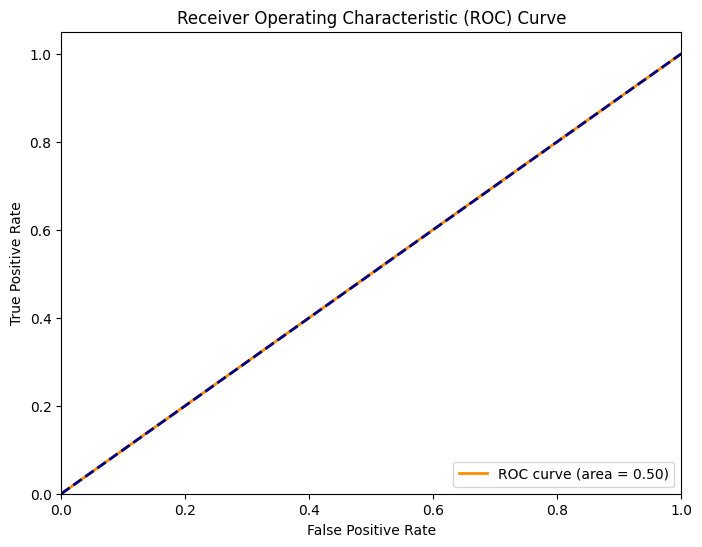

In [17]:
# Compute ROC curve and ROC-AUC
fpr, tpr, thresholds = roc_curve(y_test, predictions)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [18]:
# Create an LGBMClassifier model
lgb_model = lgb.LGBMClassifier()

# Train the model
lgb_model.fit(X_train, y_train)

# Predict using the model
predictions1 = lgb_model.predict(X_test)

# Calculate accuracy
acc_score = accuracy_score(y_test, predictions1)
print(f"The accuracy prediction is {acc_score}")

# Calculate precision
precision = precision_score(y_test, predictions1)
print("Precision:", precision)

# Calculate recall
recall = recall_score(y_test, predictions1)
print("Recall:", recall)

# Calculate F1-score
f1 = f1_score(y_test, predictions1)
print("F1-score:", f1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, predictions1)
print("Confusion Matrix:")
print(conf_matrix)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 2400717, number of negative: 2399283
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.871617 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8516
[LightGBM] [Info] Number of data points in the train set: 4800000, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500149 -> initscore=0.000598
[LightGBM] [Info] Start training from score 0.000598
The accuracy prediction is 0.49935833333333335
Precision: 0.4988150504334322
Recall: 0.5553640003404602
F1-score: 0.5255728078363365
Confusion Matrix:
[[266462 334349]
 [266421 332768]]


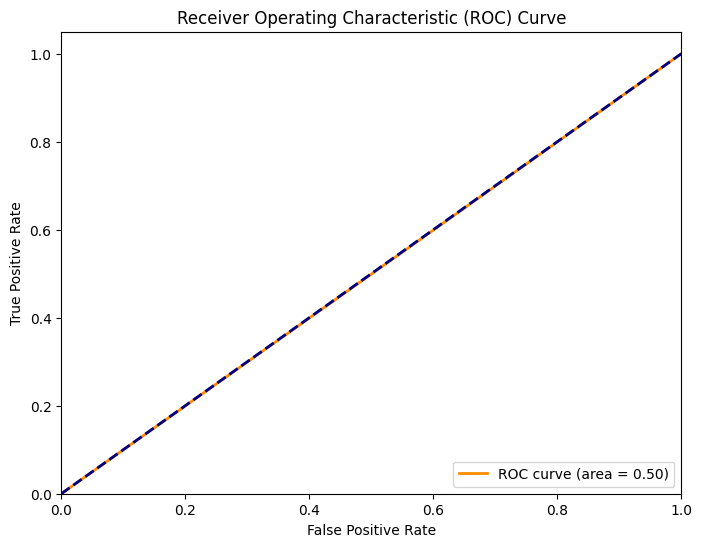

In [19]:
fpr, tpr, thresholds = roc_curve(y_test, predictions1)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

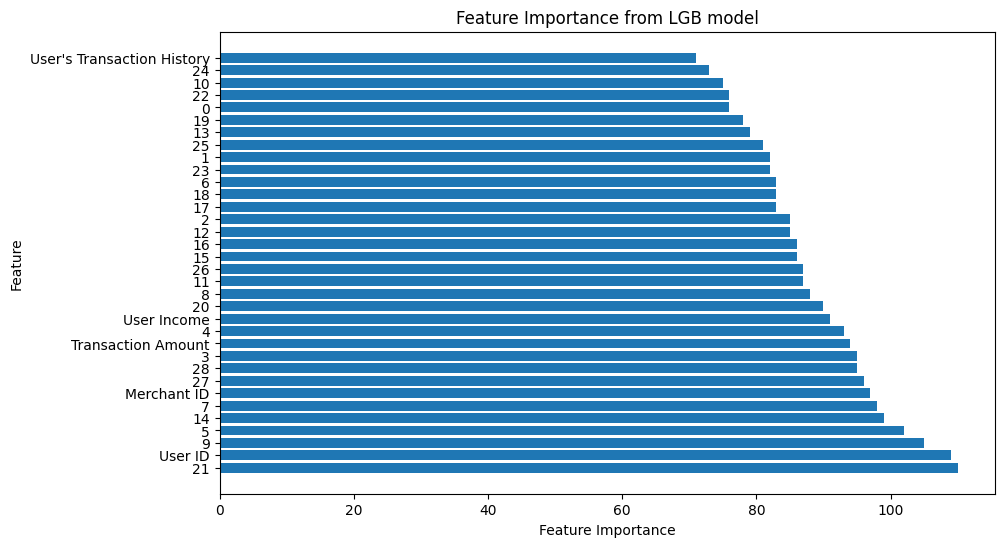

In [20]:
# Get feature importances
lgb_model_feature_importances = lgb_model.feature_importances_

feature_names = X_train.columns

# Sort the features and their importances in descending order
sorted_indices = np.argsort(lgb_model_feature_importances)[::-1]
sorted_feature_names = [feature_names[idx] for idx in sorted_indices]
sorted_importances = lgb_model_feature_importances[sorted_indices]

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_feature_names)), sorted_importances, align='center')
plt.yticks(range(len(sorted_feature_names)), sorted_feature_names)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance from LGB model')
plt.show()

In [22]:
model = Sequential()

model.add(Dense(activation = "relu", input_dim=34 , units=6 ,kernel_initializer ="uniform"))
model.add(Dropout(0.2)),

model.add(Dense(activation="relu",units=20, kernel_initializer ="uniform")),
model.add(Dropout(0.2)),

model.add(Dense(activation="relu",units=10 ,kernel_initializer ="uniform")),
model.add(Dropout(0.2)),

model.add(Dense(activation="sigmoid",units=1, kernel_initializer ="uniform"))


In [23]:
earlystopper = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',  # Quantity to be monitored (e.g., validation accuracy)
    min_delta=0,             # Minimum change in the monitored quantity to qualify as an improvement
    patience=5,             # Number of epochs with no improvement after which training will be stopped
    verbose=1,               # Controls the verbosity of the output (1: verbose, 0: quiet)
    mode='auto',             # Direction of improvement (e.g., 'auto', 'min', 'max')
    baseline=None,           # Baseline value for the monitored quantity (early stopping stops if the value goes below this baseline)
    restore_best_weights=True # Whether to restore model weights to the best values during training
)

opt = tf.keras.optimizers.Adam(learning_rate=0.001) #optimizer

model.compile(optimizer=opt, loss=tf.keras.losses.BinaryCrossentropy(), metrics=["accuracy"])

history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=1000,
    validation_data=(X_test, y_test),
    callbacks=[earlystopper]  # Include the EarlyStopping callback here
)

history_dict = history.history

Epoch 1/10
4800/4800 [==============================] - 29s 6ms/step - loss: 0.6932 - accuracy: 0.5001 - val_loss: 0.6931 - val_accuracy: 0.5007
Epoch 2/10
4800/4800 [==============================] - 29s 6ms/step - loss: 0.6932 - accuracy: 0.5003 - val_loss: 0.6932 - val_accuracy: 0.4993
Epoch 3/10
4800/4800 [==============================] - 27s 6ms/step - loss: 0.6932 - accuracy: 0.5003 - val_loss: 0.6932 - val_accuracy: 0.4993
Epoch 4/10
4800/4800 [==============================] - 26s 5ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.4993
Epoch 5/10
4800/4800 [==============================] - 24s 5ms/step - loss: 0.6932 - accuracy: 0.5002 - val_loss: 0.6931 - val_accuracy: 0.5007
Epoch 6/10
4800/4800 [==============================] - 25s 5ms/step - loss: 0.6932 - accuracy: 0.5003 - val_loss: 0.6931 - val_accuracy: 0.4993
Epoch 6: early stopping


Text(0.5, 0, 'Epochs')

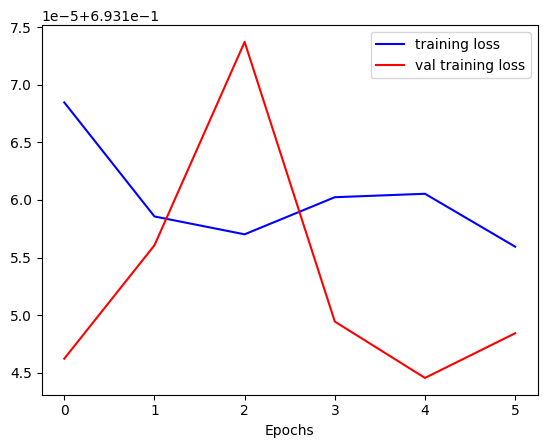

In [24]:
loss_values = history_dict['loss']
val_loss_values=history_dict['val_loss']
plt.plot(loss_values,'b',label='training loss')
plt.plot(val_loss_values,'r',label='val training loss')
plt.legend()
plt.xlabel("Epochs")